**<h1>Exploratory Data Analysis</h1>**

<img src="https://www.vapulus.com/en/wp-content/uploads/2019/08/insurance-companies.jpg" width="700" />

We'll cover EDA alongside data cleaning and feature engineering, cleaning the data as we gain insights and data trends exhibited by the data, and adding more derived features to explore the data further (eg. year feature from date columns).  
This notebook will cover the following in order:  
- **EDA and Data Cleaning**
- **Missing data imputation**
- **Feature engineering**

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("/home/lyrax/matplotlib-dracula/dracula.mplstyle")
import seaborn as sns

from tqdm import tqdm, trange

In [2]:
data = pd.read_excel("data/Claims Data 2.xlsx", parse_dates=['participant_date_of_birth', 'treatment_created_date',
                                                             'claim_finalized_date'])
data.sample(3)

,Serial Number,claim_status,provider_type,provider_region,program_type,program_cover,participant_date_of_birth,participant_gender,treatment_created_date,claim_finalized_date,item_status,item_name,item_amount,item_currency,item_quantity,total_item_amount,diagnoses,treatment_type
132532,160458.0,Approved,NaN,KISII,Insurance,OUTPATIENT,1991-07-21,MALE,2021-01-15 06:53:09,2021-01-15 07:49:22,APPROVED,Newcox- TH Tablets,152.00,KES,20,3040.00,Soft tissue disorder unspecified,OUTPATIENT
9871,191429.0,Submitted,Clinic,NAIROBI,Insurance,OUT-PATIENT,1982-09-11,FEMALE,2021-03-05 09:58:37,NaT,SUBMITTED,TOTAL CORPORATE SHARE,2937.62,KES,1,2937.62,Encounter for administrative examination,OUTPATIENT
47135,162439.0,Approved,Clinic,NAIROBI,Insurance,OUT-PATIENT,2005-03-18,MALE,2021-01-18 09:35:04,2021-01-22 08:15:08,APPROVED,OTRIVIN P NASAL DROPS,745.43,KES,1,745.43,Encounter for examination and observation for ...,OUTPATIENT


In [3]:
# shape of dataset
data.shape

(170995, 18)

In [4]:
# info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170995 entries, 0 to 170994
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Serial Number              170321 non-null  float64       
 1   claim_status               170995 non-null  object        
 2   provider_type              144502 non-null  object        
 3   provider_region            167860 non-null  object        
 4   program_type               170995 non-null  object        
 5   program_cover              170995 non-null  object        
 6   participant_date_of_birth  170989 non-null  datetime64[ns]
 7   participant_gender         170989 non-null  object        
 8   treatment_created_date     170995 non-null  datetime64[ns]
 9   claim_finalized_date       154567 non-null  datetime64[ns]
 10  item_status                170995 non-null  object        
 11  item_name                  170995 non-null  object  

In [5]:
# missing data statistics as percentage
data.isnull().sum() *100 / len(data)

Serial Number                 0.394164
claim_status                  0.000000
provider_type                15.493435
provider_region               1.833387
program_type                  0.000000
program_cover                 0.000000
participant_date_of_birth     0.003509
participant_gender            0.003509
treatment_created_date        0.000000
claim_finalized_date          9.607298
item_status                   0.000000
item_name                     0.000000
item_amount                   0.000000
item_currency                 0.000000
item_quantity                 0.000000
total_item_amount             0.000000
diagnoses                     2.800082
treatment_type                0.000000
dtype: float64

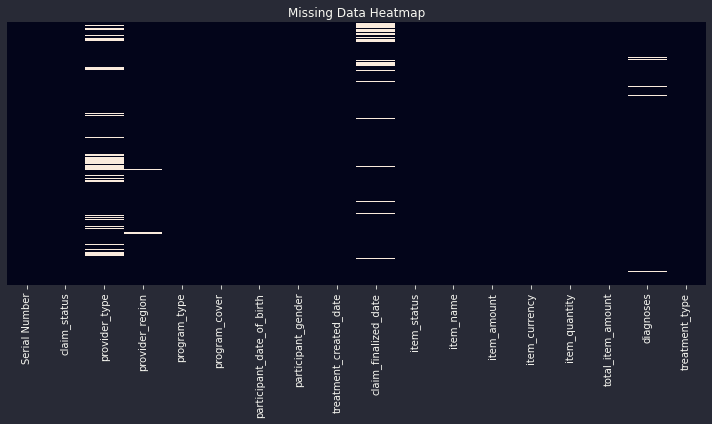

In [6]:
plt.figure(figsize=(10,6))
sns.heatmap(data.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Data Heatmap")
plt.tight_layout()
plt.savefig("plots/missing data heatmap.png", dpi=1000)

<Figure size 576x576 with 0 Axes>

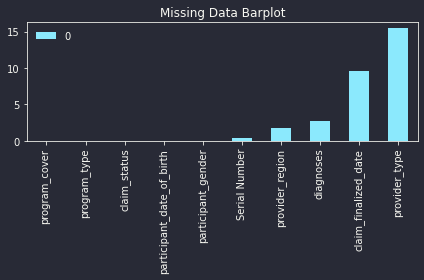

In [7]:
plt.figure(figsize=(8,8))
pd.DataFrame(pd.Series(data.isnull().sum() *100 / len(data)).sort_values()[8:]).plot(kind='bar')
plt.title("Missing Data Barplot")
plt.tight_layout()
plt.savefig("plots/missing data barplot.png", dpi=1000)

In [8]:
# Serial number
data['Serial Number'].nunique()

52187

In [9]:
len(data)

170995

Serial number column seems to be an identity column representing the customer in question.  
So the data covers information of 52187 customers.

Approved             153549
Submitted              7392
PartiallyRejected      5978
ReSubmitted            3058
Rejected               1018
Name: claim_status, dtype: int64


<AxesSubplot:xlabel='count', ylabel='claim_status'>

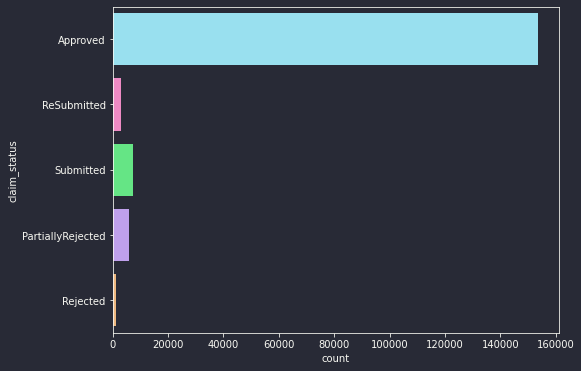

In [10]:
# claim status distribution
print(data.claim_status.value_counts())
plt.figure(figsize=(8,6))
sns.countplot(y=data.claim_status)

Let's mark the status as _Approved_ or _Not Approved_ as this is the information the company will ultimately require to know, whether an insurance claim is either approved or not.

Approved        153549
Not Approved     17446
Name: claim_status, dtype: int64 
Percentages:
 Approved        0.897974
Not Approved    0.102026
Name: claim_status, dtype: float64


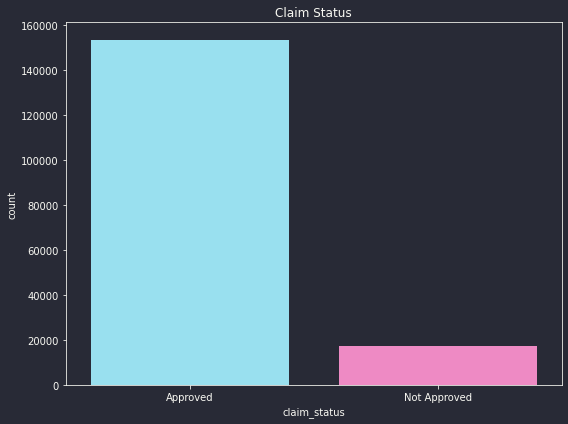

In [11]:
data.claim_status.replace(['ReSubmitted', 'Submitted', 'PartiallyRejected', 'Rejected'], 'Not Approved', inplace=True)
print(data.claim_status.value_counts(), "\nPercentages:\n", data.claim_status.value_counts(normalize=True))
plt.figure(figsize=(8,6))
sns.countplot(x=data.claim_status)

plt.title("Claim Status")
plt.tight_layout()
plt.savefig("plots/claim status distribution.png", dpi=1000)

We can see the imbalance in these two categories. We'll have to consider and be cautious of this imbalance while building a claim status classifier.  
We may consider one of the following techniques(after trying all and comparing the results):  
- Oversampling
- Undersampling
- A mixture of both oversampling and undersampling

Clinic                         106374
Hospital                        15369
Medical Clinic/ Centre           5891
Specialist                       4868
Medical Centre                   4681
Health Centre                    3706
Nursing Home                     2052
Medical Clinic                    833
Clinic, Level 1                   281
Maternity And Nursing Home        241
Primary Hospital-Category 2        85
Dentists                           76
Pharmacy                           30
Radiology Unit                     15
Name: provider_type, dtype: int64


<AxesSubplot:xlabel='count', ylabel='provider_type'>

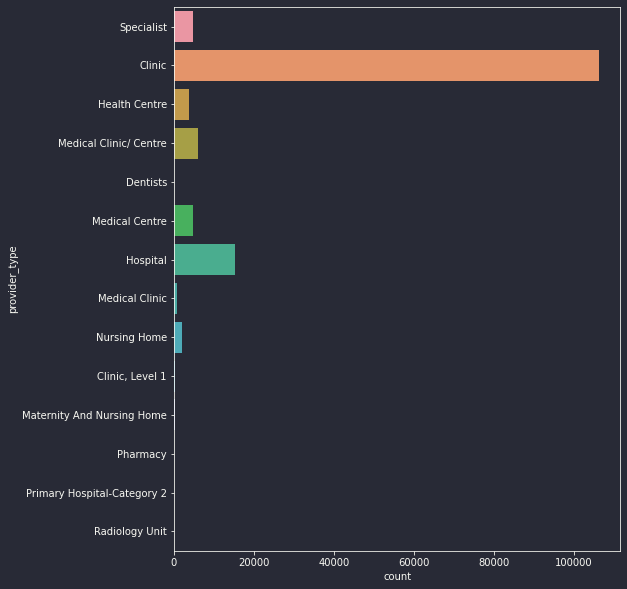

In [12]:
# provider type
print(data.provider_type.value_counts())
plt.figure(figsize=(8,10))
sns.countplot(y=data.provider_type)

Let's correct the redundancy:

Clinic            121766
Hospital           17747
Specialist          4868
Dentists              76
Pharmacy              30
Radiology Unit        15
Name: provider_type, dtype: int64


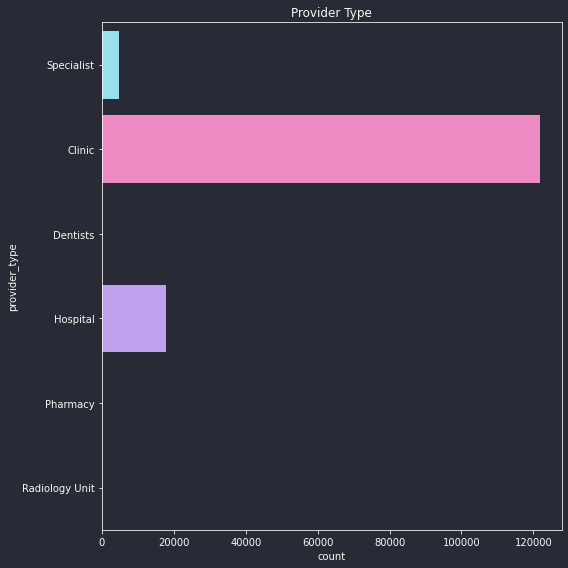

In [13]:
data.provider_type.replace(['Medical Clinic/ Centre', 'Medical Clinic', 'Clinic, Level 1', 'Medical Centre', 'Health Centre'],
                           'Clinic', inplace=True)
data.provider_type.replace(['Nursing Home', 'Maternity And Nursing Home', 'Primary Hospital-Category 2'], 'Hospital', inplace=True)

print(data.provider_type.value_counts())
plt.figure(figsize=(8,8))
sns.countplot(y=data.provider_type)

plt.title("Provider Type")
plt.tight_layout()
plt.savefig("plots/provider type distribution.png", dpi=1000)

In [14]:
# provider region
print(f"Number of regions: {data.provider_region.nunique()}\n")
print(data.provider_region.value_counts())

Number of regions: 46

NAIROBI            69785
MOMBASA            15038
KISUMU              9964
KIAMBU              8480
KAKAMEGA            6596
NAKURU              4621
BUNGOMA             4553
KAJIADO             4206
TRANS-NZOIA         4073
UASIN GISHU         4033
KISII               2954
KERICHO             2816
NYERI               2611
MIGORI              2529
MACHAKOS            2448
KILIFI              2289
NANDI               2198
LAIKIPIA            2017
MERU                1861
GARISSA             1450
BUSIA               1428
SIAYA               1326
EMBU                1297
HOMABAY             1264
BARINGO             1242
KIRINYAGA           1125
TAITA-TAVETA        1025
KITUI                924
TURKANA              606
BOMET                397
MAKUENI              383
ISIOLO               359
WAJIR                342
KWALE                313
MURANG'A\n           285
VIHIGA               245
NAROK                211
WEST POKOT           137
MARSABIT             115
TH

Region clearly represents counties.

In [15]:
# correct error in MURANG'A listing
data.provider_region.replace("MURANG'A\n", "MURANG'A", inplace=True)

In [16]:
# program type
data.program_type.value_counts()

Insurance    170995
Name: program_type, dtype: int64

In [17]:
# drop the program type column as it has only one unique value
data.drop('program_type', axis=1, inplace=True)

In [18]:
# program cover
data.program_cover.value_counts()

OUT-PATIENT                                           124976
OUTPATIENT                                             27489
Outpatient                                              5243
DENTAL                                                  4235
OPTICAL                                                 2875
outpatient                                              2135
AAR - OP                                                1281
OUT-PATIENT                                              965
Out-Patient                                              296
OUTPATIENT                                               223
Dental                                                   205
Out Patient                                              201
ANNUAL MEDICAL CHECK-UP                                  165
SPECTACLE FRAME                                          150
Optical                                                  115
BABY FRIENDLY VACCINES / WELL BABY CLINIC                 93
OUTPATIENT              

Remove redundancy:

In [19]:
data.program_cover.unique()

array(['DENTAL', 'OUTPATIENT', 'OUT-PATIENT', 'AAR-Outpatient',
       'outpatient', 'OPTICAL', 'OUT-PATIENT ', 'Dental', 'Outpatient',
       'Annual check up', 'OUTPATIENT ', 'ANNUAL_CHECKUP', 'Out-Patient',
       'VACCINES - PRIVATE VACCINES', 'Well Baby Clinic', 'AAR - OP',
       'ANNUAL MEDICAL CHECK-UP', 'Out Patient',
       'BABY FRIENDLY VACCINES / WELL BABY CLINIC', 'OUTPATIENT   ',
       'ANNUAL MEDICAL CHECK-UP FOR MAIN MEMBER / EMPLOYEE',
       'ANNUAL_CHECK-UP', 'dental', 'MATERNITY', 'ANNUAL CHECKUP',
       'ANNUAL MEDICAL CHECK-UP at AAR healthcare clinics',
       'BABY FRIENDLY VACCINES', 'Baby Friendly', 'AAR - Dental',
       'SPECTACLE FRAME', 'Optical', 'AAR - Optical',
       'AAR - Spectacle Frame', 'optical', 'AAR- Checkup'], dtype=object)

In [20]:
data.program_cover.replace(['OUT-PATIENT', 'AAR-Outpatient', 'outpatient', 'OUT-PATIENT ', 'Outpatient', 'OUTPATIENT ',
                           'Out-Patient', 'AAR - OP', 'Out Patient', 'OUTPATIENT   '], 'OUTPATIENT', inplace=True)
data.program_cover.replace(['Dental', 'dental', 'AAR - Dental'], 'DENTAL', inplace=True)
data.program_cover.replace(['Optical', 'AAR - Optical', 'optical', 'SPECTACLE FRAME', 'AAR - Spectacle Frame'], 'OPTICAL', inplace=True)
data.program_cover.replace(['Annual check up', 'ANNUAL_CHECKUP', 'ANNUAL MEDICAL CHECK-UP',
                            'ANNUAL MEDICAL CHECK-UP FOR MAIN MEMBER / EMPLOYEE', 'ANNUAL_CHECK-UP',
                            'ANNUAL MEDICAL CHECK-UP at AAR healthcare clinics', 'AAR- Checkup'], 'ANNUAL CHECKUP', inplace=True)
data.program_cover.replace(['VACCINES - PRIVATE VACCINES', 'Well Baby Clinic', 'BABY FRIENDLY VACCINES / WELL BABY CLINIC',
                           'MATERNITY', 'BABY FRIENDLY VACCINES', 'Baby Friendly'], 'BABY FRIENDLY', inplace=True)

data.program_cover.unique()

array(['DENTAL', 'OUTPATIENT', 'OPTICAL', 'ANNUAL CHECKUP',
       'BABY FRIENDLY'], dtype=object)

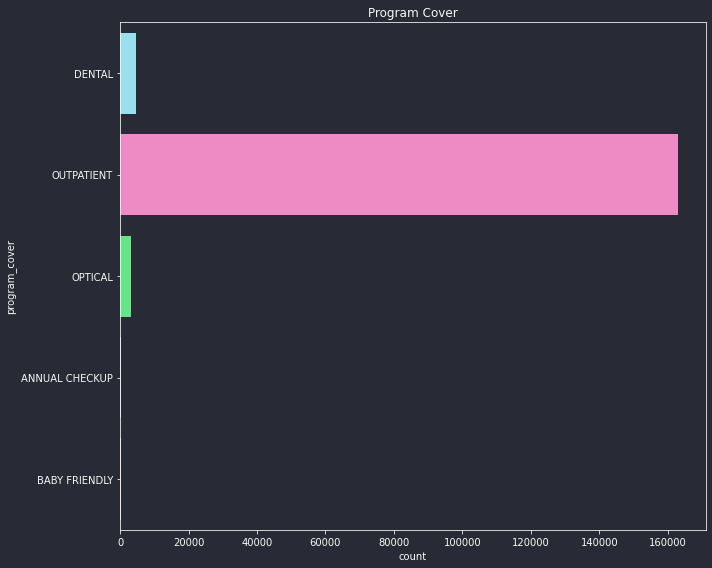

In [21]:
plt.figure(figsize=(10,8))
sns.countplot(y=data.program_cover)

plt.title("Program Cover")
plt.tight_layout()
plt.savefig("plots/program cover distribution.png", dpi=1000)

In [22]:
# oldest participant/customer
print(f"Oldest participant is {2021 - data.participant_date_of_birth.min().year} years old\n\
Date of birth: {data.participant_date_of_birth.min()}")

Oldest participant is 93 years old
Date of birth: 1928-10-05 00:00:00


In [23]:
# youngest
print(f"Youngest participant is {2021 - data.participant_date_of_birth.max().year} years old\n\
Date of birth: {data.participant_date_of_birth.max()}")

Youngest participant is 0 years old
Date of birth: 2021-07-01 00:00:00


In [24]:
# save below two cells for feature engineering
# new features from DOB

In [25]:
"""data['participant_yearOB'] = data.participant_date_of_birth.dt.year.astype(int)
data['participant_monthOB'] = data.participant_date_of_birth.dt.month.astype(int)
data['participant_dayOB'] = data.participant_date_of_birth.dt.day.astype(int)

data.sample(3)"""

"data['participant_yearOB'] = data.participant_date_of_birth.dt.year.astype(int)\ndata['participant_monthOB'] = data.participant_date_of_birth.dt.month.astype(int)\ndata['participant_dayOB'] = data.participant_date_of_birth.dt.day.astype(int)\n\ndata.sample(3)"

In [26]:
#data.participant_date_of_birth.dt.day_name().map({'Monday': 'weekday', 'Tuesday': 'weekday', 'Wednesday': 'weekday',
 #                                                 'Thursday': 'weekday', 'Friday': 'weekday', 'Saturday': 'weekend', 'Sunday': 'weekend'})

FEMALE    95751
MALE      75238
Name: participant_gender, dtype: int64


<AxesSubplot:xlabel='participant_gender', ylabel='count'>

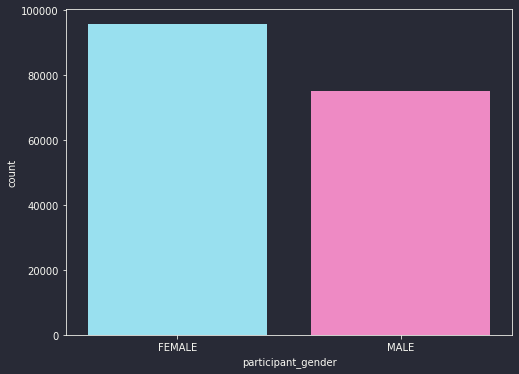

In [27]:
# gender
print(data.participant_gender.value_counts())
plt.figure(figsize=(8,6))
sns.countplot(x=data.participant_gender)

In [28]:
# treatment date
# earliest
data.treatment_created_date.min()

Timestamp('2020-12-31 01:02:12')

In [29]:
# latest
data.treatment_created_date.max()

Timestamp('2021-04-01 04:47:40')

In [30]:
# claim finalized date
data.claim_finalized_date.min()

Timestamp('2020-12-31 06:24:42')

In [31]:
data.claim_finalized_date.max()

Timestamp('2021-03-31 20:53:27')

APPROVED     152792
SUBMITTED     16726
REJECTED       1477
Name: item_status, dtype: int64


<AxesSubplot:xlabel='item_status', ylabel='count'>

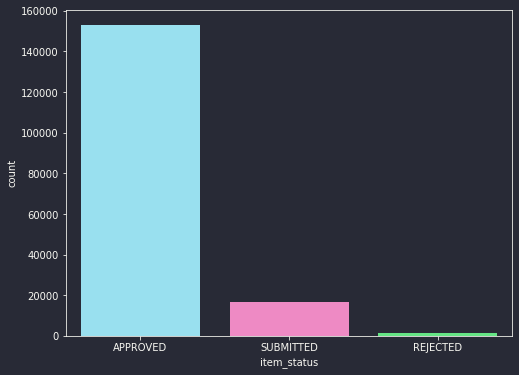

In [32]:
# item status
print(data.item_status.value_counts())
plt.figure(figsize=(8,6))
sns.countplot(x=data.item_status)

Are approved items have meaning that the claim is approved?  
Let's inspect:

In [33]:
data.claim_status.value_counts()

Approved        153549
Not Approved     17446
Name: claim_status, dtype: int64

Items under 'SUBMITTED' are awaiting approval or rejection.  
This is a great feature, that is if it's not a leakage feature, such that the item status is determined at the health providers prior to being pushed to the insurance company.  
To verify it's not a leakage feature let's see if there are cases where item status is rejected and claim status is approved:

In [34]:
len(data[(data.item_status == "REJECTED") & (data.claim_status == 'Approved')])

458

There are a number of such cases!  
So there is no leakage. It's either item status or claim status is determined first.

In [35]:
# item name
data.item_name.value_counts()[:20]

TOTAL CORPORATE SHARE              12977
Consultation General Practioner    10941
Consultation  - Specialist          2470
Full Haemogram (FHG)                2458
CONSULTATION FEE                    1716
FULL BLOOD COUNT (HAEMOGRAM)        1682
FULL HAEMOGRAM                      1509
Consultation General Outpatient     1357
Lenses                              1238
Consultation                        1129
Frames                              1093
Revist Consultation                 1067
C - Reactive Protein (Crp)          1064
MALARIAL PARASITES (THIN FILM)      1052
OUT PATIENT CLINIC CONSULTATION      810
Consultation Paediatric Clinic       799
Dental Consultation                  719
Consultation - Clinical officer      713
 Urinalysis                          654
CBC/PBF + MPS                        651
Name: item_name, dtype: int64

Item name seems to state the reason for healthcare consultation. There also seem to be a lot of redundancy but given that the number of unique values in this column is almost 10000, it would be tedious to remove the redundancy. We can use text vectorization techniques may be, or text frequencies, after converting all text to lowercase.

/home/lyrax/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='item_amount', ylabel='Density'>

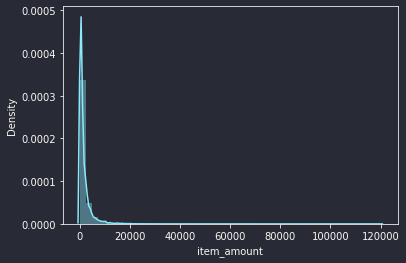

In [36]:
# item amount
sns.distplot(data.item_amount)

In [37]:
# max and min amount
print(f"max: {data.item_amount.max()}\nmin: {data.item_amount.min()}")

max: 120000.0
min: 0.0


In [38]:
# number of amounts greater than 20k
len(data[data.item_amount > 20000])

517

In [39]:
# drop item currency column since it has only one unique value
data.drop('item_currency', axis=1, inplace=True)

In [40]:
# item quantity
data.item_quantity.value_counts()[:20]

1     128908
10      9962
30      5840
2       4372
14      3489
20      2795
5       2211
15      2109
3       1939
7       1467
60      1166
6       1060
28       661
18       628
9        612
4        538
16       406
21       362
12       325
8        272
Name: item_quantity, dtype: int64

In [41]:
data.diagnoses.value_counts()

Encounter for administrative examination                           21769
Encounter for examination and observation for other reasons         7993
Acute upper respiratory infection unspecified                       6268
Acute nasopharyngitis [common cold]                                 3594
Acute pharyngitis                                                   3393
                                                                   ...  
Renal agenesis unspecified                                             1
Burn and corrosion of hip and lower limb; except ankle and foot        1
Other nutritional deficiencies                                         1
Encounter for fitting and adjustment of unspecified device             1
Osteochondrodysplasia unspecified                                      1
Name: diagnoses, Length: 7112, dtype: int64

Diagnosis is another statistic that we might require to use text vectorization to be able to include this information in modeling.

In [58]:
# drop treatment type as it has only one unique value
data.drop('treatment_type', axis=1, inplace=True)

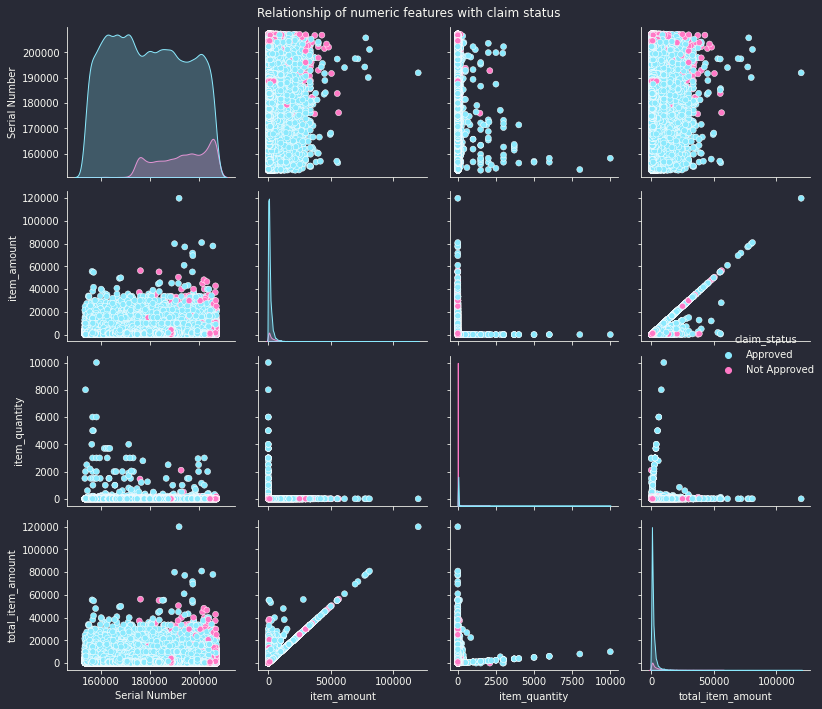

In [44]:
# pairplot
sns.pairplot(data, hue='claim_status')
plt.suptitle("Relationship of numeric features with claim status", y=1.08)
plt.tight_layout()
plt.savefig("plots/pairplot-feature relationships with claim status.png", dpi=1000)

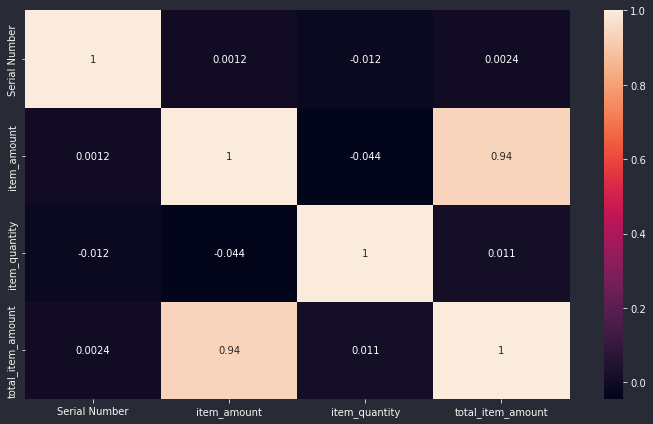

In [50]:
# heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), annot=True)
plt.tight_layout()
plt.savefig("plots/correlation heatmap.png", dpi=1000)

## **EDA Summary**
- The column with most missing data is provider_type with 15.49% missing data points, followed by claim_finalized_date with 9.6%, rest have <3% missing data points. Visual representation in the missing data heatmap and barplot charts.
- Taking serial number as an identity column, the data represents information of 52187 customers.
- To reduce claim status to 2 most important valid categories, marked Resubmitted, Submitted, PartiallyRejected and Rejected categories as Not Approved.  
We have =~ 89.8% Approved claims and =~ 10.2% Not Approved.  
To take care of this imbalance, we might have to explore balancing techniques such as oversampling, undersampling or both.
- Corrected redundancy in provider_type column from 14 to 6 categories. See the provider type distribution chart.
- Also corrected redundancy in program_cover from =~35 to 5 categories. See program cover distribution chart.
- Participants are divided into 56% female and 44% males across gender.
- In item status column, items under 'SUBMITTED' are awaiting approval or rejection.  
Item status is a great feature, that is if it's not a leakage feature, such that the item status is determined at the health provider prior to being pushed to the insurance company (or that the claim is first decided upon, before a customer goes to the health provider).  
To test if this is a leakage feature we investigate to see if there are cases where item status is rejected and claim status is approved and see that there are a number of such cases!(458 in total)  
So we conclude there is no leakage. It's either item status or claim status is determined first.  

-----

# **Missing Data Imputation**

In [119]:
# In progress